In [77]:
import h3ppy
import pysynphot as S
import wget
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm as lognorm
import numpy as np
import pandas as pd
import os
import scipy
import scipy.io as sio
from scipy.io import readsav
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
from pathlib import Path
import glob
plt.rcParams.update({'font.size': 16}) #make font on graphs big :)

In [33]:
#______________________________________#
#general information needed (examples shown):


order = "1" #currently set up to handle "1", "4", and "3" (if 3 has been dealt with) in echelle setting 1
genpath = "Y:/obs_23/Keck_29Dec/spec" #directory where data files are being stored
            #expected path structure:
                #genpath/eXoX/data + wave cal
            #where eXoX is the echelle setting (usually 1 for standard Keck stuff) and order (currently using 1,3,4
            #need access to all orders to be reduced
#the final created "path" variable (determined by which order you're reducing) will be where files are saved (starspec, fluxcal, data, etc)

#additional files needed (path is within one of the order directories, just need the name and file type):
dark = '/nspec231230_0001_dark.fits'
star = '/nspec231230_0026_star7Tri.fits'
sky  = '/nspec231230_0044_sky.fits'

#______________________________________#
#information for calibration:


#name to use to search for flat files:
flatname = "flat" #really just a word that only appears in this kind of file's name

#which star files to pull - value determined by counting your own star files, might be some trial & error in figuring out which ones to use:
#needed to add these indexes because sometimes the first star file isn't in an A or B position on the slit
#can generally leave at 1 and 9 (assuming 8 star exposures) if all exposures are being used
startindex_star = 1 #index of first star you want to use (start at 1)
endindex_star = 9 #index of last star you want to use + 1 (start at 1)

#name to use to search for star files:
starname = "7Tri" #really just a word that only appears in this kind of file's name

#link to seeing information:  http://mkwc.ifa.hawaii.edu/current/seeing/index.cgi
#if the auto-finding seeing info breaks (aka if they didn't take data) you can input the value by hand here, otherwise leave commented
#seeing = 0.65

#choose the model for your star - chosen here is an A0V which should cover our stars
#different star types and their inputs can be found here in Table 2: 
#https://www.stsci.edu/hst/instrumentation/reference-data-for-calibration-and-tools/astronomical-catalogs/kurucz-1993-models
#model suite: 'k93models', effective temperature: 9520, metallicity: 0, gravity (log(g)): 4.14
#the 4th input, 0, is for metallicity which always seems to be 0 for these models
Kurucz_model = S.Icat('k93models', 9520, 0, 4.14)

#K-band star magnitude from values on SIMBAD: http://simbad.u-strasbg.fr/simbad/
#star used here was 7 Tri
star_magnitude =  5.228 

#______________________________________#
#apply flux calibration to data:


#name to use to search for jupiter files:
jupname = "Jup" #really just a word that only appears in this kind of file's name
#name to use to search for sky files:
skyname = "sky" #really just a word that only appears in this kind of file's name
#______________________________________#

In [34]:
#update paths and stuff when changing the directory
#this sets all save & load directories currently based on order

if order == '1':
    ordername = "First"
    path = genpath + r"\e1o1"
    
    #you might need to check where the wavecal file is saved, but everything below this does not need to be changed
    wave_e1o1_list = sio.readsav(path + "/wavelength.sav", verbose=False, python_dict = True)
    wave_e1o1 = wave_e1o1_list['wavelength']
    wave_micron = wave_e1o1 #wavelength file in microns
    wave_ang = wave_e1o1*10000 #wavelength file in angstroms
    print(order)
    
elif order == '3':
    ordername = "Third"
    path = genpath + r"\e1o3" 
    
    wave_e1o3_list = sio.readsav(path + "/wavelength.sav", verbose=False, python_dict = True)
    wave_e1o3 = wave_e1o3_list['wavelength']
    wave_micron = wave_e1o3 #wavelength file in microns
    wave_ang = wave_e1o3*10000 #wavelength file in angstroms
    
    print(order)
    
elif order == '4':
    ordername = "Fourth"
    path = genpath + r"\e1o4"
    
    wave_e1o4_list = sio.readsav(path + "/wavelength.sav", verbose=False, python_dict = True)
    wave_e1o4 = wave_e1o4_list['wavelength']
    wave_micron = wave_e1o4 #wavelength in microns
    wave_ang = wave_e1o4*10000 #wavelength in angstroms
    
    print(order)
    


else:
    print("Error in detecting order")

1


In [35]:
#open general fits files from data to pull information from header on setup
                #such as slit size, ccd pixels, etc
fitspath = path + dark 
fitsarray = fits.open(fitspath)


starpath = path + star 
stararray = fits.open(starpath)


skypath = path + sky
skyarray = fits.getdata(skypath)

In [36]:
#create function to read in all files with a specific name in a folder

In [37]:
#below pulled from Keck Fits Flux Calibration

Y:/obs_23/Keck_29Dec/spec\e1o1\nspec231230_0011_flat.fits
Y:/obs_23/Keck_29Dec/spec\e1o1\nspec231230_0012_flat.fits
Y:/obs_23/Keck_29Dec/spec\e1o1\nspec231230_0013_flat.fits
Y:/obs_23/Keck_29Dec/spec\e1o1\nspec231230_0014_flat.fits
Y:/obs_23/Keck_29Dec/spec\e1o1\nspec231230_0015_flat.fits
Y:/obs_23/Keck_29Dec/spec\e1o1\nspec231230_0016_flat.fits
Y:/obs_23/Keck_29Dec/spec\e1o1\nspec231230_0017_flat.fits
Y:/obs_23/Keck_29Dec/spec\e1o1\nspec231230_0018_flat.fits
Y:/obs_23/Keck_29Dec/spec\e1o1\nspec231230_0019_flat.fits
Y:/obs_23/Keck_29Dec/spec\e1o1\nspec231230_0020_flat.fits


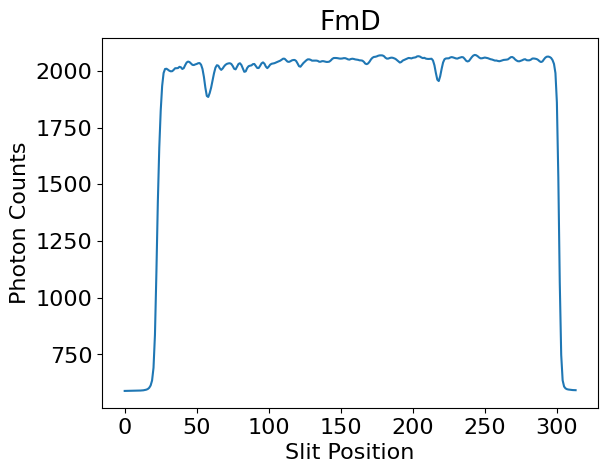

Y:/obs_23/Keck_29Dec/spec\e1o1\nspec231230_0026_star7Tri.fits
Created starA1
Y:/obs_23/Keck_29Dec/spec\e1o1\nspec231230_0027_star7Tri.fits
Created starB1
Y:/obs_23/Keck_29Dec/spec\e1o1\nspec231230_0028_star7Tri.fits
Created starB2
Y:/obs_23/Keck_29Dec/spec\e1o1\nspec231230_0029_star7Tri.fits
Created starA2
Y:/obs_23/Keck_29Dec/spec\e1o1\nspec231230_0030_star7Tri.fits
Created starA3
Y:/obs_23/Keck_29Dec/spec\e1o1\nspec231230_0031_star7Tri.fits
Created starB3
Y:/obs_23/Keck_29Dec/spec\e1o1\nspec231230_0032_star7Tri.fits
Created starB4
Y:/obs_23/Keck_29Dec/spec\e1o1\nspec231230_0033_star7Tri.fits
Created starA4


In [39]:
#function to correct individual files for the impact of coadds on the integration time
def coaddsint(path):
    
    arrlist = get_pkg_data_filename(path)
    start = fits.getdata(arrlist, ext=0)
    #print(np.max(start), np.min(start))
    
    fitsarr = fits.open(path)
    itime = fitsarr[0].header['TRUITIME'] #time integrated
    #print(itime)
    coadds = fitsarr[0].header['COADDS'] #number of integrations for a single file
    #print(coadds)
    time = itime * coadds #total time based on coadds
    #print(time)
    finalarr = start/time #convert file from counts to counts/sec for later flux calibration
    #print(np.max(finalarr), np.min(finalarr))
    
    return(finalarr)

#flats
flatFiles = glob.glob(path + "/*.fits") #search for all fits files in directory
flatarr = 0 #array to put all of the flats into
flatcount = 0
trueflatcount = 0
startindex = 0
endindex = 10
for flatfilename in flatFiles:
    if flatname in flatfilename: #specifically pull out any files with "flat" in name
        flatcount = flatcount + 1
        if flatcount >= startindex and flatcount <= endindex:
            print(flatfilename)
            trueflatcount = trueflatcount + 1
            flatcoadds = coaddsint(flatfilename) #run codds&int time  function on each file
            flatarr = flatcoadds + flatarr #add all flats together
            #print(np.max(flatarr), np.min(flatarr))
flat = flatarr/trueflatcount


FmD = flat/np.max(flat)
FmD = FmD + (1 - np.median(FmD)) #normalize flat to 1


plt.plot(np.sum(FmD, axis = 1))
plt.title("FmD")
plt.xlabel("Slit Position")
plt.ylabel("Photon Counts")
plt.show()

newpath = path + r"\cal" #create cal path if one doesn't already exist; it should in the current file structure though
if not os.path.exists(newpath):
    os.makedirs(newpath)

np.save(path + r"\cal\FmD_firsthalf.npy", FmD) #save flat within cals folder

    
#stars
starFiles = glob.glob(path + "/*.fits") #search for all fits files in director
starcount = 0
starlabel = 0


startindex = startindex_star
endindex = endindex_star
starA = []
starB = []

for starfilename in starFiles:
    if starname in starfilename: #specifically pull out any files with "star" in name
        starcount = starcount + 1 #counter to keep track of how many files are being opened
        #print(starcount)
        fitshead = fits.open(starfilename)
        fitsarr = fits.getdata(starfilename)
        stardisc = fitshead[0].header['OBJECT'] #check name of star
        #print(stardisc) #make sure the star is the same for all files
        maxstar = (np.sum(fitsarr, axis = 1)).argmax() #find position of the trace on the slit
        
        if starcount >= startindex and starcount <= endindex: #set boundaries for which stars to use
            if maxstar > (len(fitsarr))/2: #assign stars with peak in "bottom" of slit with "B"
                print(starfilename)
                starlabel = starlabel + 0.5
                starB.append(coaddsint(starfilename))
                #locals()["starB"+str(int(starlabel+0.5))] = coaddsint(starfilename) #creates variable for each star
                print("Created starB"+str(int(starlabel+0.5))) #tells you name of all of the created star variables
                
            elif maxstar < (len(fitsarr))/2: #assign stars with peak in "top" of slit with "A"
                print(starfilename)
                starlabel = starlabel + 0.5
                starA.append(coaddsint(starfilename))
                #locals()["starA"+str(int(starlabel+0.5))] = coaddsint(starfilename) #creates variable for each star
                print("Created starA"+str(int(starlabel+0.5))) #tells you name of all of the created star variables
            else:
                print("Error in determining peak position")
                
starpairs = np.int64(starcount/2) #number of AB pairs - used for graphing below

#make array of star pair differences
stardifflist = []
for i in range(starpairs):
    stardiff = (starA[i] - starB[i]) / FmD #creating A-B star pairs
    stardifflist.append(stardiff)

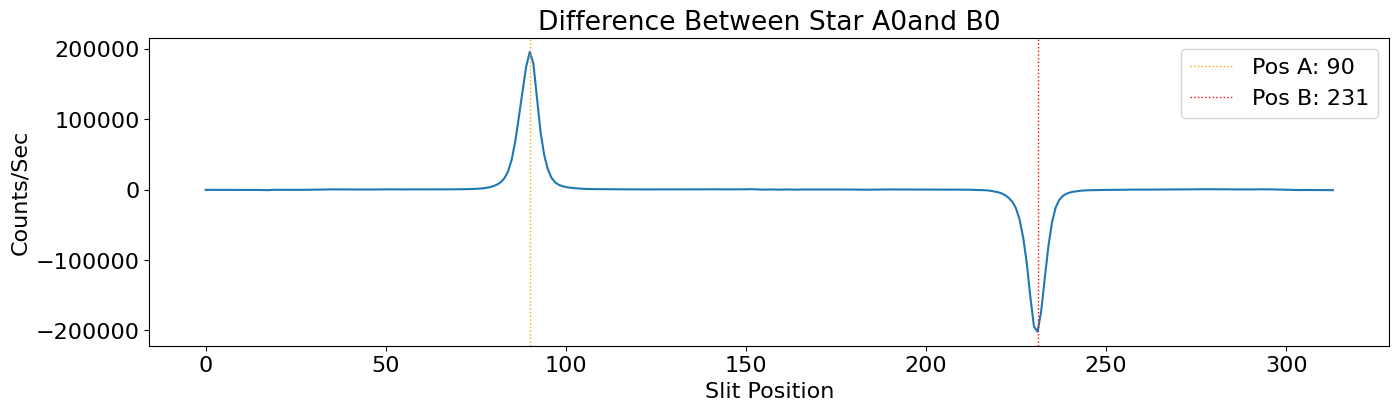

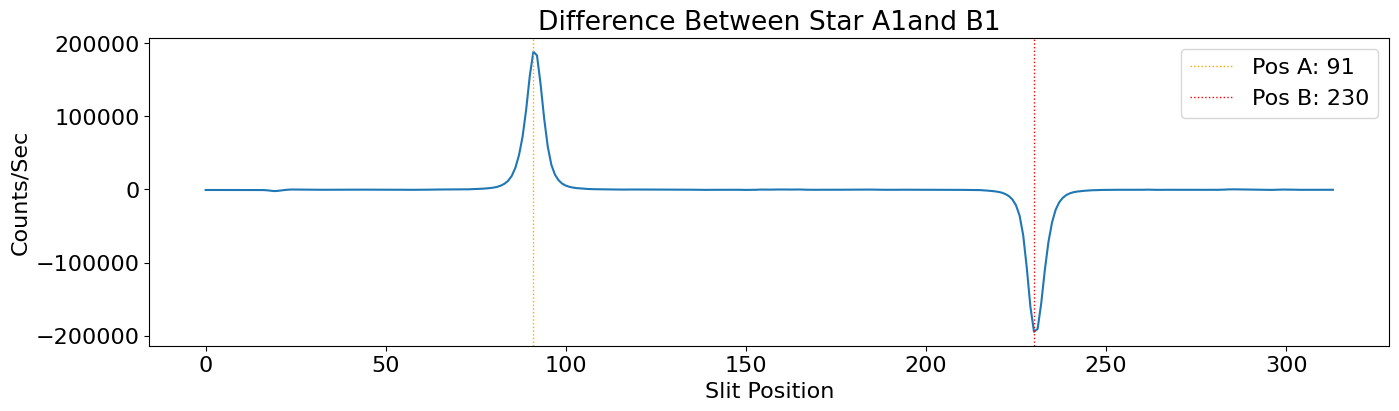

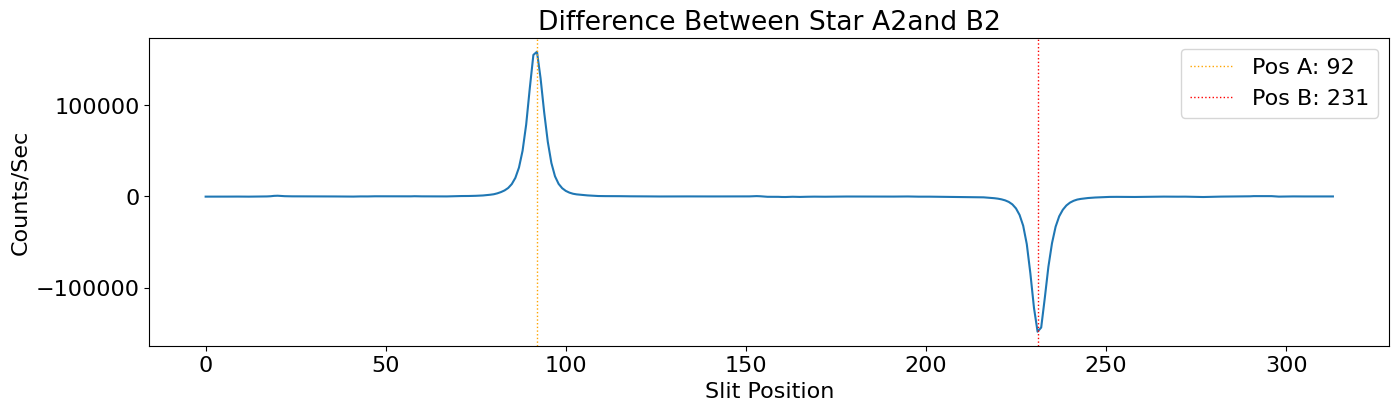

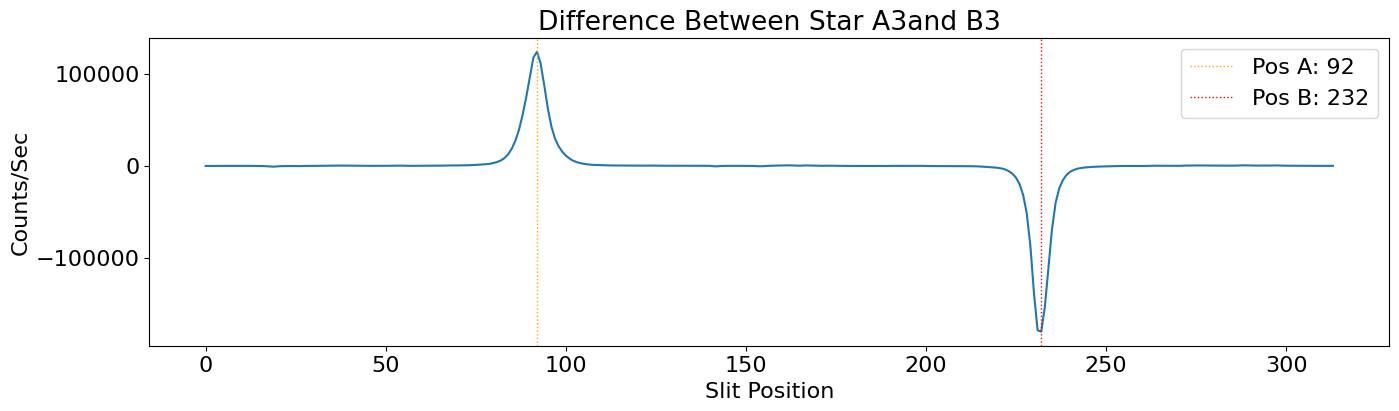

In [40]:
#a whole buncha plots showing the final A-B stars;
#just to check that everything looks as expected (2 peaks in each graph, one positive, one negative)
#and to make sure that the "peak finding" method works for the next step

for i in range(starpairs):
    plt.figure(figsize=(16, 4))
    plt.plot(np.sum(stardifflist[i], axis = 1))
    plt.axvline(x = np.sum(stardifflist[i][10:-10], axis = 1).argmax()+10, linestyle = ':',color = 'orange', linewidth = 1, 
           label = "Pos A: " + str(np.sum(stardifflist[i][10:-10], axis = 1).argmax()+10))
    plt.axvline(x = np.sum(stardifflist[i][10:-10], axis = 1).argmin()+10, linestyle = ':',color = 'red', linewidth = 1, 
           label = "Pos B: " + str(np.sum(stardifflist[i][10:-10], axis = 1).argmin()+10))
    plt.title("Difference Between Star A" + str(i) + "and B" + str(i))
    plt.legend()
    plt.xlabel("Slit Position")
    plt.ylabel("Counts/Sec")
    plt.show()

In [41]:
peakwidth = 20
#function to pull out just the peaks of stars in a single A-B data frame
#stardiff: an A-B frame (so the max and min values within some range vertically
                                #should correspond to an A and B respectfully)
#width: the width of the peak (adds to each side of max/min) - 20 should be fine
                        #want some extra room to play with for gaussian fit

def pullstarpeaks(stardiff, width = peakwidth):
#eventually make the width automated via seeing/pixel scale
    
    Alist = []
    Blist = []
    
    ymax = np.sum(stardiff[10:-10], axis = 1).argmax() + 10 #finds positive peak index from spectrum summed in wavelength
    ymin = np.sum(stardiff[10:-10], axis = 1).argmin() + 10 #find negative peak index from spectrum summed in wavelength
    
    #print(ymax)
    #print(ymin)
    index = 0
    
    for i in range(len(stardiff[0])): #now finding each peak at those indexes for each position in wavelength
        index = index + 1
        
        Amaxlow = ymax-width
        Amaxhigh = ymax+width
        #print(stardiff[ymax, i])
        finalpeakA = stardiff[Amaxlow:Amaxhigh, i]
        Alist.append(finalpeakA)
       

        Bminlow = ymin-width
        Bminhigh = ymin+width
        finalpeakB = stardiff[Bminlow:Bminhigh, i]
        #print(stardiff[ymin, i])
        Blist.append(finalpeakB)
        

    return np.asarray(Alist),np.asarray(Blist)

In [42]:
Apeakslist = np.zeros((len(wave_micron), 2*peakwidth))
Bpeakslist = np.zeros((len(wave_micron), 2*peakwidth))

for i in range(starpairs):

    allpeaks = pullstarpeaks(stardifflist[i])
    Apeakstemp = allpeaks[0]
    Bpeakstemp = allpeaks[1]
    
    Apeakslist = Apeakslist + Apeakstemp
    Bpeakslist = Bpeakslist + Bpeakstemp
    
    

Apeaks = Apeakslist / starpairs
Bpeaks = Bpeakslist / starpairs

In [43]:
#gaussian function - self explanatory
def _1gaussian(x, amp1,cen1,sigma1):
    return amp1*(1/(sigma1*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2)))

    
#function to fit gaussians to all of the peaks
#y_array: just the y-data of the star peaks
def gaussianfitall(y_array):
    fits   = []
    result = []
    uncert = []


    for i in range(len(y_array)):
        
        x_array = range(len(y_array[i]))
        y_array_gauss = y_array[i]

        width = len(y_array[i]) #peak should be the center of every array
        amp = y_array[i][int(width/2)] #"guess" for amplitude

        cen = len(y_array[i])/2 #"guess" for centroid
        sigma = 2 #guess for sigma
        x = range(len(y_array[i]))
        
        #sometimes the fits get angry so it needed a lot of iterations (maxfev) to make it not crash
        popt_gauss, pcov_gauss = scipy.optimize.curve_fit(_1gaussian, x_array, y_array[i], 
                                                          p0=[amp, cen, sigma], maxfev=100000)
        fits.append(_1gaussian(x_array, *popt_gauss))

        perr_gauss = np.sqrt(np.diag(pcov_gauss))
        #print(perr_gauss)
        result.append(popt_gauss)
        #print(popt_gauss)
        uncert.append(perr_gauss)
        
        
            

    return fits,result,uncert

In [44]:
Afits = gaussianfitall(Apeaks)
Bfits = gaussianfitall(Bpeaks*-1) #we no longer need the B peaks to be negative; it was just easy to find the peaks with -B

Afit = Afits[0] #use only the fits, the other stuff is only saved just in case
Bfit = Bfits[0]

In [45]:
#function to integrate area under the gaussian fit
#fit: gaussian fit to data
#data: peaks pulled from full data
#width: width of area to integrate; finds center of data then does +/- width
def integrate(fit, data, width):
    area = []
    count = 0

    for i in range(len(fit)):
        peakindex = int(len(fit[1])/2) #index of the gaussian peak
        
        #calculated area from gaussian fit
        areagauss = scipy.integrate.trapezoid(fit[i][peakindex-width:peakindex+width+1],
                                            range(len(fit[i][peakindex-width:peakindex+width+1])))
        #calulated area from data
        areadata = scipy.integrate.trapezoid(data[i,peakindex-width:peakindex+width+1],
                                           range(len(data[i,peakindex-width:peakindex+width+1])))

        
        diff = np.abs(areagauss - areadata)/areadata #find difference between calculated areas; helps find especially bad fits

        if diff > 0.2:
            print("Index of bad fit: " + str(i) + ", error = " + str(round(diff*100, 2)))
            if areadata < 10:
                #very small values will get divided out and become very big; this is bad
                #enforce min area of 10
                print("Very small value at index " + str(i) )
                count= count + 1
                area.append(int(10))
            else:    
                area.append(areadata) #when it seems like the gaussian didn't capture the shape of the star peak well
                                      #just use the integrated area of the original data instead; doesn't happen often
        else:
            
            if areadata < 10:
                #very small values will get divided out and become very big; this is bad
                #enforce min area of 10
                print("Very small value at index " + str(i) )
                count= count + 1
                area.append(int(10))
            else:    
                area.append(areagauss)

    return area




#function to integrate area under the data
#data: peaks pulled from full data
#width: width of area to integrate; finds center of data then does +/- width
def integratedata(data, width):
    area = []

    for i in range(len(data)):
        peakindex = int(len(data[1])/2) #index of the gaussian peak
        
        #calulated area from data
        areadata = scipy.integrate.trapezoid(data[i,peakindex-width:peakindex+width+1],
                                           range(len(data[i,peakindex-width:peakindex+width+1])))
        
        #print(areadata)
        
        area.append(areadata)
    return area

In [46]:
Aarea_int = integratedata(Apeaks, 20)

In [47]:
Barea_int = integratedata(Bpeaks*-1, 20)

In [48]:
#here, C is the average starspec from the A and B peaks
#A and B can differ slightly depending on how well centered the star was on the slit
#fixes to come to try and include that difference via information from SCAM
Carea_int = (np.array(Aarea_int) + np.array(Barea_int))/2

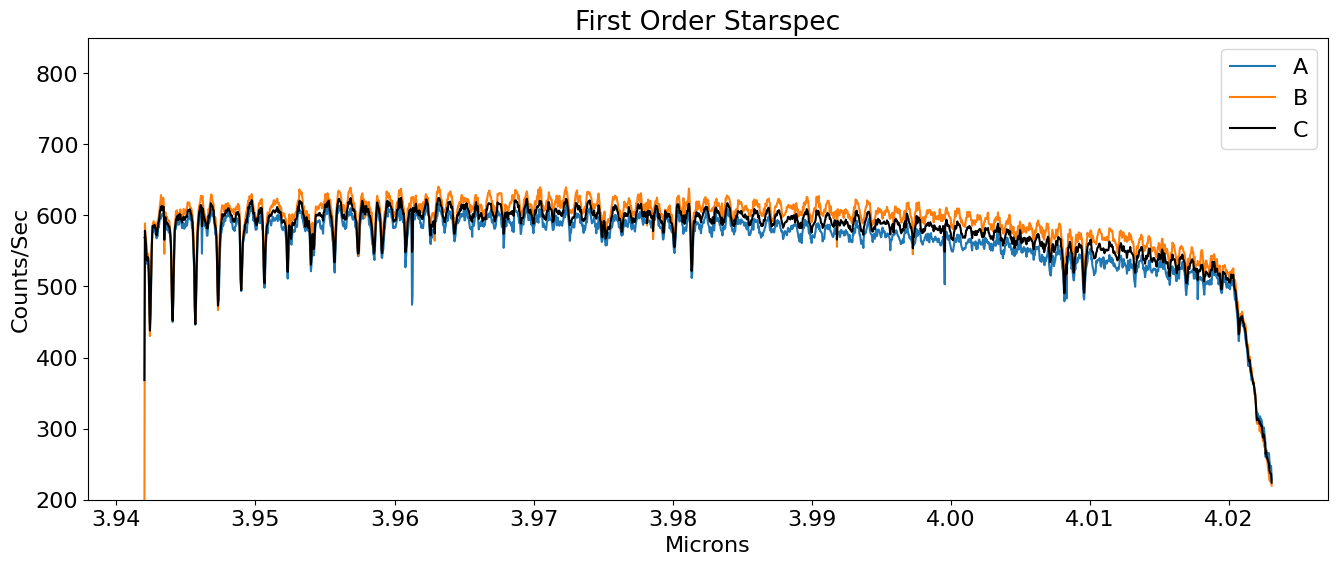

In [49]:
plt.figure(figsize=(16, 6))
plt.plot(wave_micron, Aarea_int, label = "A")
plt.plot(wave_micron, Barea_int, label = "B")
plt.plot(wave_micron, Carea_int, color='black', label = 'C')

plt.title(ordername + " Order Starspec")
plt.xlabel("Microns")
plt.ylabel("Counts/Sec")
plt.ylim(200,850)
plt.legend()
plt.show()

In [50]:
#final units here are counts/sec
#choose which starspec to save based on above figure and how the peaks looked earlier on
#default is average
print("Decide which starspec to use: A, B, C (avg A&B)")
starspec = np.array(Carea_int)
#starspec = np.array(Aarea_int)
#starspec = np.array(Barea_int)

#automatically chooses where to save starspec based on the order being reduced
if order == '1':
    np.save(path + r"\starspec1.npy", starspec)

elif order == '3':
    np.save(path + r"\starspec3.npy", starspec)

elif order == '4':
    np.save(path + r"\starspec4.npy", starspec)

else:
    print("Error detecting chosen order")

Decide which starspec to use: A, B, C (avg A&B)


In [51]:
#now moving into "Keck Fits Files General"
#to begin creating the actual "Fcal" to apply to the data

In [52]:
#"gaussstar" equivalent:

slitname = fitsarray[0].header['SLITNAME']
print("Size of slit: " + str(slitname))
#if slitname == "0.432x24":
#    slitwidth = 0.432
#elif slitname == "0.288x24":
#    slitwidth = 0.288
#else:
#    print("Input Correct Slit Width")

slitwidth = np.array(str(slitname)[0:5]).astype(float)
print("Inputted Slit Width:", slitwidth)

Size of slit: 0.288x24
Inputted Slit Width: 0.288


In [56]:
timeUTstar = stararray[0].header["UT"] #assuming HH:MM:SS
datestar = stararray[0].header["DATE-OBS"] #assuming YYYY-MM-DD

yyyydate = datestar[0:4]
mmdate = datestar[5:7]
dddate = datestar[8:10]

hourHSTstar = float(timeUTstar[0:2]) - 10 #10 hour differenc bewteen UT and HST
if hourHSTstar < 0:
    hourHSTstar = 24 + hourHSTstar
        
HSTstar = hourHSTstar + float(timeUTstar[3:5])/60 + float(timeUTstar[6:11])/3600

url = 'http://mkwc.ifa.hawaii.edu/current/seeing/dimm/' + yyyydate + mmdate + dddate + ".dimm.dat"
filename = wget.download(url)
file = pd.read_csv(filename, header = None, delimiter = " ")

timearr = []
seeingarr = []
for index, row in file.iterrows():
    seeingtime = float(row[3]) + float(row[4])/60 + float(row[5])/3600
    seeing = float(row[6])
    timearr.append(seeingtime)
    seeingarr.append(seeing)
    
seeing = seeingarr[np.abs(np.asarray(timearr) - HSTstar).argmin()]

os.remove(filename) #deletes file after creating it for this - quite handy

#this can break if the data for that night doesn't exist which is rough - try the link below if that's the case
#seeing = 0.65 #THING TO UPDATE WITH NEW DATA
print("Check seeing; inputted:", seeing)

Check seeing; inputted: 1.13


In [57]:
#the star would be a point source if no seeing; because the light is dispersed it can be dispersed outside of the slit
#determine how much light is actually being taken in from a point source based on:
    #size of slit & how much the light is spread from seeing
    
    
#there shouldn't be anything that needs updating here

see  = seeing
slit = slitwidth 

#FWHM = seeing and FWHM = 2.355*sigma, so sigma = FWHM/2.355
sig = see/2.355  #seeing in arcseconds [converts between FWHM and 1 sigma]
mu=0

xarr = ((np.array(range(0, 10000, 1)))/1000.) - 5.
parr = []

for x in range(len(xarr)-1):
    arr = (1/(sig * np.sqrt(2*np.pi)) )*np.exp( -((xarr[x]-mu)**2)/(2*sig**2) ) #gaussian
    parr.append(arr)
parr = np.array(parr)



L = mu - (slit/2.) #left side of gaussian to find the min light captured by the slit
LHwh = np.abs(xarr-L).argmin()
LH = parr[LHwh]

R = mu + (slit/2.)  #right side of gaussian to find the max light captured byt the slit
RHwh = np.abs(xarr-R).argmin()
RH = parr[RHwh]

perc = np.sum(parr[LHwh:RHwh]) / np.sum(parr) #calculate percentage of total

print("Percent of flux captured by slit: " + str(round(perc*100, 2)) + "% (1 sigma)")

Percent of flux captured by slit: 23.59% (1 sigma)


In [58]:
starfinal = starspec/perc #apply "gausstar" info; what percentage of light at each wavelength is actually getting into slit

print("Make sure original flux max (", round(np.max(starfinal),2), \
      ") is greater than corrected flux max (", round(np.max(starspec),2), ")")

Make sure original flux max ( 2648.21 ) is greater than corrected flux max ( 624.72 )


In [59]:
#this section uses pysynphot & the Kurucz star atlas
#load in star spectrum: 7Tri #THING TO UPDATE WITH NEW DATA (what star was used)
# A0V kp00_9500[g40] 
#need T_eff = 9520, metallicity = 0, log(g) = 4.14
sp = Kurucz_model #this is the kurucz entry for an A0V star
#sp = S.Icat('k93models', 10000, 0, 4.14)


#configure star spectrum into something the bandpass can normalize
Kurucz = S.ArraySpectrum(sp.wave, sp.flux)

In [60]:
vega_flux = 4.07e-10 #specific for K-band
#UPDATE m_star from values on SIMBAD
#star used here was 7 Tri
#print("Update K-band star magnitude with SIMBAD")
#http://simbad.u-strasbg.fr/simbad/
m_star =  star_magnitude #THING TO UPDATE WITH NEW DATA (magnitude of observed star within the specific wavelength range being used)
starflux = vega_flux * (10**(-0.4*m_star)) 
print(starflux)


#W/m^2/micron * 10^-1 for the conversion of um, m^2, and W, to AA, cm^2, erg/s
constant = starflux*10**(-1)


#center of band being used; in this case, K-band
band_wl = 2.2 #microns
band_ang = 22000 #angstroms

3.29909186763148e-12


21950.0
Value model is being normalized to: 5.204312975703065e-19
Correct Normalization


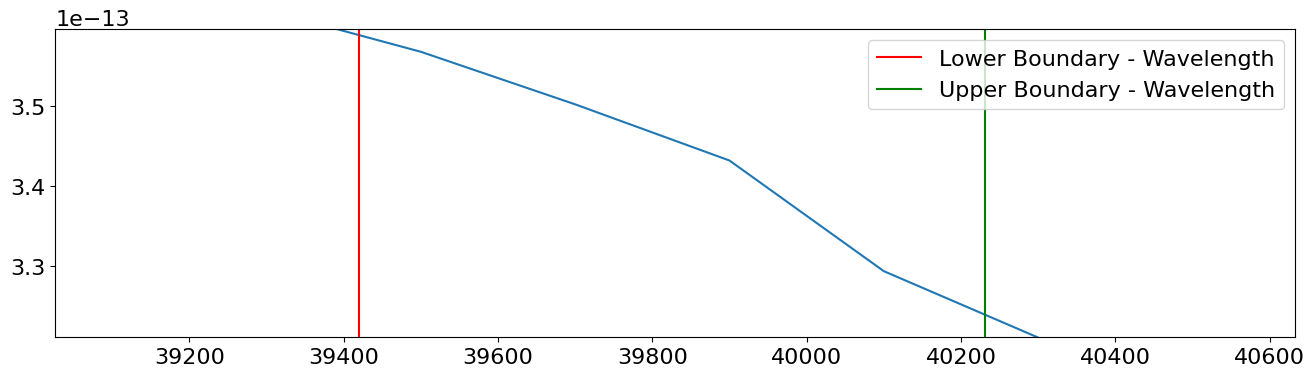

In [61]:
#find index of center of band for normalization at center of order band
#normalize to center of K-band (where the star mag is from)
number = np.abs(Kurucz.wave - band_ang).argmin()
#print(number)
print(Kurucz.wave[number])


#normalize the model spectrum to the magnitude of the star
starnorm = constant/Kurucz.flux[number]
Kurucz_band = starnorm*Kurucz.flux


#some checks to make sure things are working correctly:
print("Value model is being normalized to: " + str(starnorm))

if np.abs(Kurucz_band - constant).argmin() == number:
    print("Correct Normalization")
else:
    print("Incorrect Normalization")
    
    
## model is in units of erg/s/cm^2/AA, want it to be W/m^2/micron
Kurucz_W = (Kurucz_band)*10

#look at region of star model being used; mostly to see if there are any interesting absorption features
maxy = Kurucz_W[np.abs(Kurucz.wave - np.max(wave_ang)).argmin()]
miny = Kurucz_W[np.abs(Kurucz.wave - np.min(wave_ang)).argmin()]
    
plt.figure(figsize=(16, 4))
plt.plot(Kurucz.wave, Kurucz_W)
#plt.plot(wave_ang, Ibb, color = "black", label = "bb")
plt.xlim(np.min(wave_ang)-np.min(wave_ang)*0.01, np.max(wave_ang)+np.max(wave_ang)*0.01)
plt.ylim(miny-0.1*miny, maxy+0.12*maxy)
#plt.ylim(3.2e-13, 3.9e-13)

plt.axvline(x = np.min(wave_ang), label = "Lower Boundary - Wavelength", color = "r")
plt.axvline(x = np.max(wave_ang), label = "Upper Boundary - Wavelength", color = "g")
plt.legend()
plt.show()

In [62]:
#interpolate Kurucz spectrum to calibrator wavelengths so they are the same size & at same wavelengths
final_constant = np.interp(wave_ang, Kurucz.wave, Kurucz_W)
#print(final_constant)

if len(final_constant) == len(wave_ang):
    print("Correct Interpolation")
else:
    print("Incorrect Interpolation")

Correct Interpolation


In [63]:
fluxcal = final_constant/starfinal

In [64]:
# Need to convert the instrument FOV to units of sterradian
# The pixel width is 0.098 arcsec with a slit width of 0.288 arcsec (NIRSPEC High resolution echelle)
# Note - there are 4.2545e10 arceconds in a sterradian

#final units here are now W/m^2/micron/str/count

platescale = fitsarray[0].header['SPATSCAL']
print("Plate Scale: " + str(platescale) + " arcsec")


fluxcal_str = fluxcal * 4.2545e10 / (platescale * slitwidth)

#fluxcal_bb_str = fluxcal_bb * 4.2545e10 / (platescale * slitwidth)

#save final fluxcal
if order == "1":
    np.save(path + '/fluxcal1_str.npy', fluxcal_str)
elif order == "3":
    np.save(path + '/fluxcal3_str.npy', fluxcal_str)
elif order == "4":
    np.save(path + '/fluxcal4_str.npy', fluxcal_str)
else:
    print("Error detecting chosen order")

Plate Scale: 0.129 arcsec


In [65]:
#load final fluxcal
if order == "1":
    fluxcal_str = np.load(path + '/fluxcal1_str.npy')
elif order == "3":
    fluxcal_str = np.load(path + '/fluxcal3_str.npy')
elif order == "4":
    fluxcal_str = np.load(path + '/fluxcal4_str.npy')
else:
    print("Error detecting chosen order")

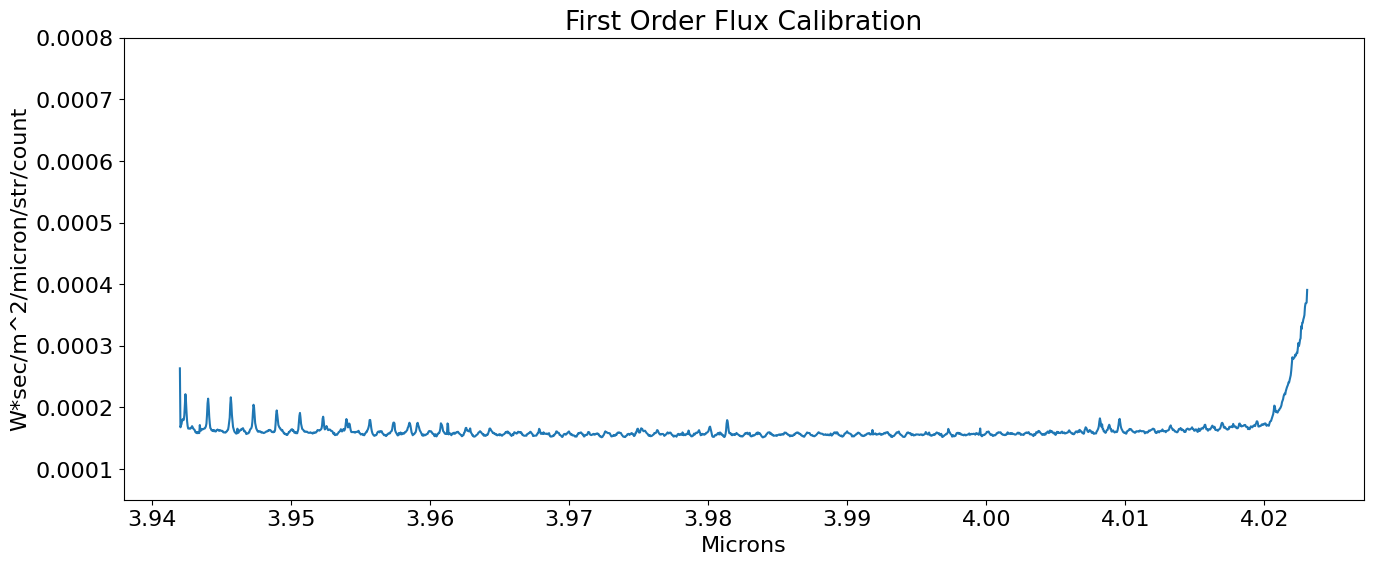

In [67]:
#comparing fluxcals just to see differences
plt.figure(figsize=(16, 6))
plt.plot(wave_micron, fluxcal_str)


plt.title(ordername + " Order Flux Calibration")
plt.ylabel("W*sec/m^2/micron/str/count")
plt.xlabel("Microns")
#plt.legend()
plt.ylim(0.00005,0.0008)
plt.show()

In [74]:
#things to check & update here:

#what keywords are being used to pull file names
    #basic should be "jup" and "sky" but may need to specify "jupS", "jupN", "jupEq", "Jup (capitalized)"

#function to apply take difference between A and B frames and then apply flat
def ABFlat(A,B,Flat):
    C = (A - B)/(Flat)
    return C

newpath = path + "/Reduction Files" #creates new directory if it doesn't already exist
if not os.path.exists(newpath):
    os.makedirs(newpath)


#sky frames
skyFiles = glob.glob(path + "/*.fits") #search for all fits files in directory
skytime_list = []
skyname_list = []
skylabel = 0

for skyfilename in skyFiles:
    if skyname in skyfilename: #THING TO UPDATE WITH NEW DATA
        skyfitsarr = fits.open(skyfilename)
        skytime = skyfitsarr[0].header['MJD'] #find the time the sky frame was taken
        #print(f_name, skytime)
        skytime_list.append(skytime)
        skyname_list.append(skyfilename)

        
#jupiter frames
jupFiles = glob.glob(path + "/*.fits") #search for all fits files in directory
jupcount = 0
jupframes = []

for jupfilename in jupFiles:
    if jupname in jupfilename and skyname not in jupfilename: #THING TO UPDATE WITH NEW DATA
        jupfitsarr = fits.open(jupfilename)
        f_name, f_ext = os.path.splitext(os.path.join(path, jupfilename))
        print("Jupiter File Name: " + str(jupfilename))
        juptime = jupfitsarr[0].header['MJD'] #find the time the Jup fram was taken
        
        index = np.abs(np.asarray(skytime_list) - juptime).argmin()
        starfitsarr = fits.open(skyname_list[index])
        print("Sky File Name: " + str(skyname_list[index]))
        jupcoadds = coaddsint(jupfilename) #do the coadd corrections
        skycoadds = coaddsint(skyname_list[index])
        jup = ABFlat(jupcoadds,skycoadds,FmD) #apply the flat
        
        
         #saves the sky-subtracted, flat-corrected file with its original file name (continuity)
        np.save(newpath + "/" + Path(f_name).stem + "_e1o" + order, jup)

Jupiter File Name: Y:/obs_23/Keck_29Dec/spec\e1o1\nspec231230_0035_JupN.fits
Sky File Name: Y:/obs_23/Keck_29Dec/spec\e1o1\nspec231230_0034_sky.fits
Jupiter File Name: Y:/obs_23/Keck_29Dec/spec\e1o1\nspec231230_0036_JupS.fits
Sky File Name: Y:/obs_23/Keck_29Dec/spec\e1o1\nspec231230_0034_sky.fits
Jupiter File Name: Y:/obs_23/Keck_29Dec/spec\e1o1\nspec231230_0037_JupN.fits
Sky File Name: Y:/obs_23/Keck_29Dec/spec\e1o1\nspec231230_0039_sky.fits
Jupiter File Name: Y:/obs_23/Keck_29Dec/spec\e1o1\nspec231230_0038_JupS.fits
Sky File Name: Y:/obs_23/Keck_29Dec/spec\e1o1\nspec231230_0039_sky.fits
Jupiter File Name: Y:/obs_23/Keck_29Dec/spec\e1o1\nspec231230_0040_JupN.fits
Sky File Name: Y:/obs_23/Keck_29Dec/spec\e1o1\nspec231230_0039_sky.fits
Jupiter File Name: Y:/obs_23/Keck_29Dec/spec\e1o1\nspec231230_0041_JupS.fits
Sky File Name: Y:/obs_23/Keck_29Dec/spec\e1o1\nspec231230_0039_sky.fits
Jupiter File Name: Y:/obs_23/Keck_29Dec/spec\e1o1\nspec231230_0042_JupN.fits
Sky File Name: Y:/obs_23/Keck

Y:/obs_23/Keck_29Dec/spec\e1o1\Reduction Files\nspec231230_0040_JupN_e1o1.npy


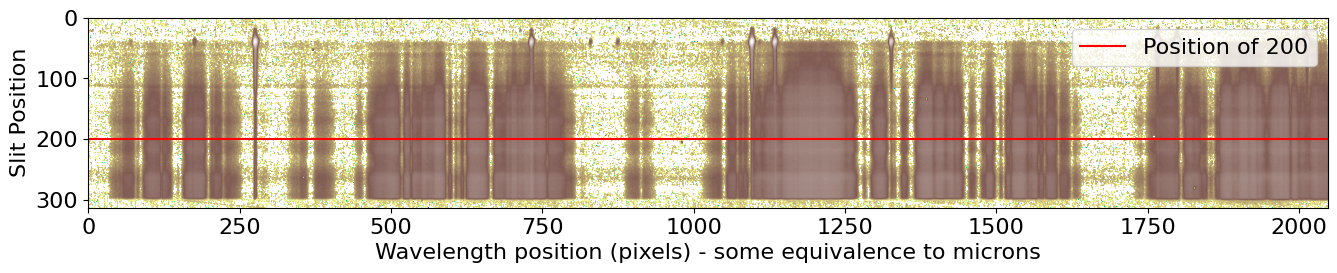

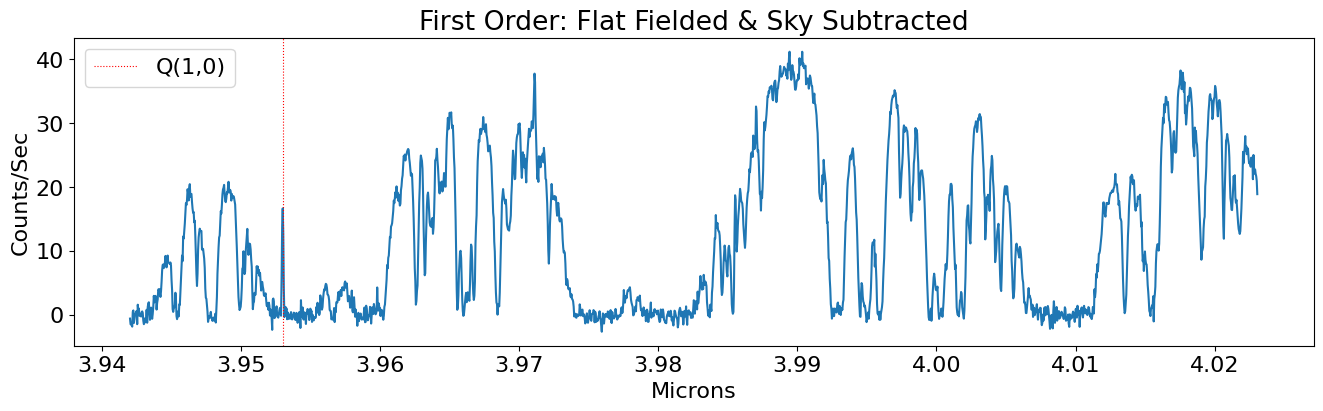

In [82]:
#this is literally just to look at a file and make sure it looks okay
your_path = path + r"\Reduction Files"
files = os.listdir(your_path)
index = 0
for file in files:
    if os.path.isfile(os.path.join(your_path, file)):
        index = index + 1
        
        if index == 5: #can put any number here to pull a different file (smaller than # of jup files)
            jup = np.load(os.path.join(your_path, file))
            print(os.path.join(your_path, file))


#num is slit position; usually chosen to be in auroral region for clearer h3+ emissions
num = 200

plt.figure(figsize=(16, 12))
plt.imshow(jup, cmap='terrain', norm = lognorm())
plt.axhline(y = num, color = 'red', label = "Position of " + str(num))
plt.xlabel("Wavelength position (pixels) - some equivalence to microns")
plt.ylabel("Slit Position")
plt.legend()
plt.show()

plt.figure(figsize=(16, 4))
plt.plot(wave_micron, jup[num])
plt.title(ordername + " Order: Flat Fielded & Sky Subtracted")
plt.xlabel("Microns")
plt.ylabel("Counts/Sec")
#check lines to be used for h3ppy fits
if order == "1":
    plt.axvline(x = 3.95299, color = 'Red', label = "Q(1,0)", linewidth = 0.8, linestyle = ":")
elif order ==  "4":
    plt.axvline(x = 3.41488, color = "r", linewidth = 0.8, linestyle = ":", label = "R(3,1)")
    plt.axvline(x = 3.42071, color = "r", linewidth = 0.8, linestyle = ":", label = "R(3,2)")
    plt.axvline(x = 3.45475, color = "r", linewidth = 0.8, linestyle = ":", label = "R(4,3)")
plt.legend()
plt.show()

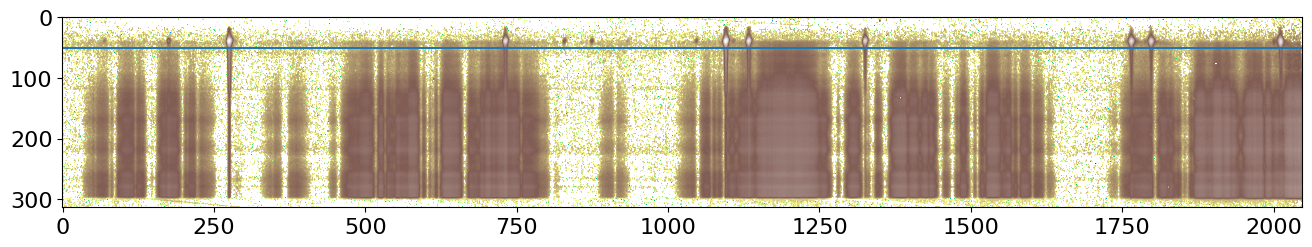

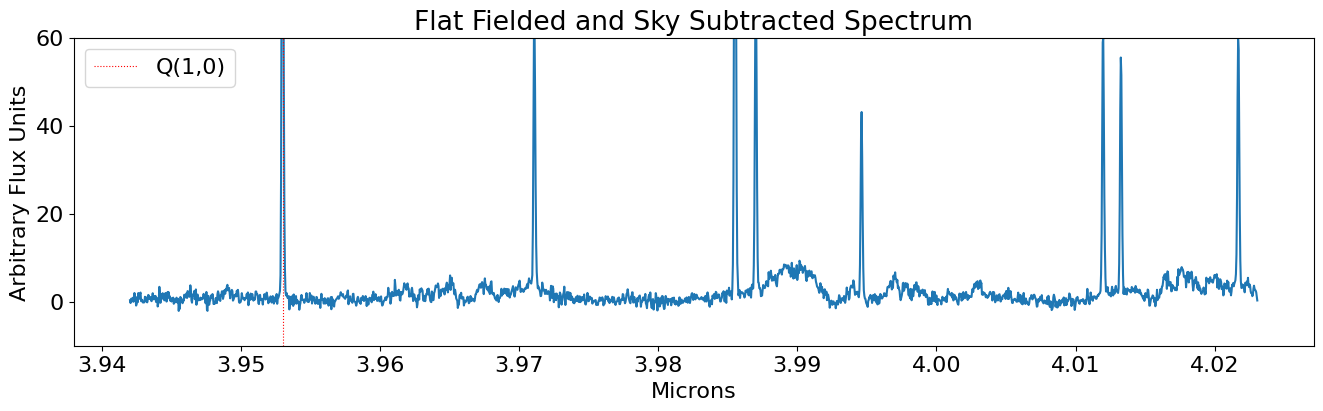

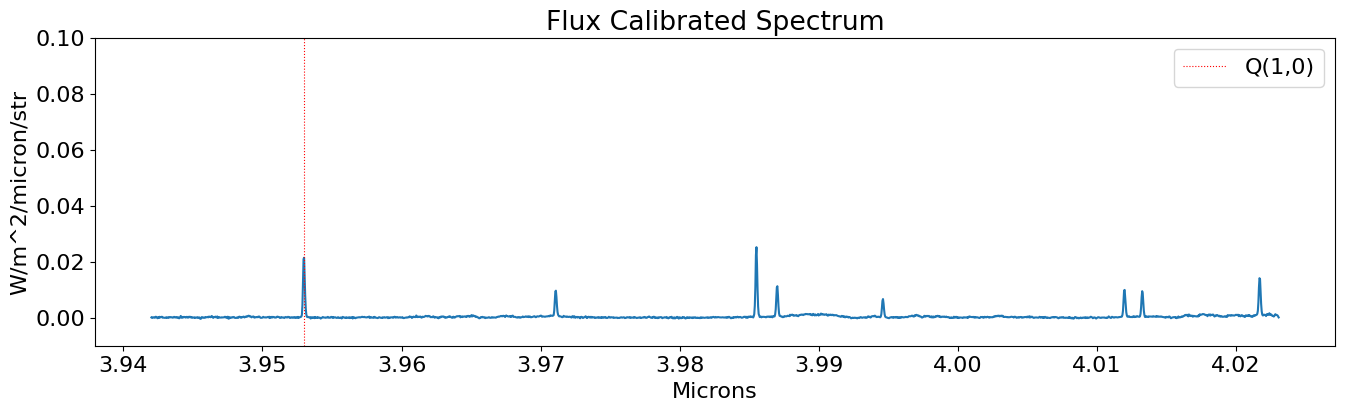

In [86]:
#apply fluxcal to all data & save

newpath = path + "/Reduction Files/fcal data" #make directory if it doesn't already exist
if not os.path.exists(newpath):
    os.makedirs(newpath)
            
index = 0 #literally just for picking a file to graph
your_path = path + "/Reduction Files"
files = os.listdir(your_path)
for file in files:
    if os.path.isfile(os.path.join(your_path, file)):
        f_name, f_ext = os.path.splitext(os.path.join(your_path, file)) #pull name of file
        jup = np.load(os.path.join(your_path, file))
        jup_final = jup * fluxcal_str #multiply by fluxcal
        index = index + 1
        
            
        np.save(
           path + "/Reduction Files/fcal data/" + Path(f_name).stem + "_final.npy", jup_final #save with original file name
               )
#plot file in directory to see before/after fluxcal
        if index == 1: #can change to any file you want, starting from 0
            num = 50 #slit position; usually chosen to be in auroral region
            
            plt.figure(figsize=(16, 4))
            plt.imshow(jup_final, norm = lognorm(), cmap = "terrain")
            plt.axhline(y = num)
            plt.show()
                        
            plt.figure(figsize=(16, 4))
            plt.plot(wave_micron,jup[num])
            if order == "1":
                plt.axvline(x = 3.95299, color = 'Red', label = "Q(1,0)", linewidth = 0.8, linestyle = ":")
            elif order ==  "4":
                plt.axvline(x = 3.41488, color = "r", linewidth = 0.8, linestyle = ":", label = "R(3,1)")
                plt.axvline(x = 3.42071, color = "r", linewidth = 0.8, linestyle = ":", label = "R(3,2)")
                plt.axvline(x = 3.45475, color = "r", linewidth = 0.8, linestyle = ":", label = "R(4,3)")
            plt.ylim(-10, 60)
            plt.xlabel("Microns")
            plt.ylabel("Arbitrary Flux Units")
            plt.title("Flat Fielded and Sky Subtracted Spectrum")
            plt.legend()
            plt.show()
                        
            plt.figure(figsize=(16, 4))
            plt.plot(wave_micron,jup_final[num])
            if order == "1":
                plt.axvline(x = 3.95299, color = 'Red', label = "Q(1,0)", linewidth = 0.8, linestyle = ":")
            elif order ==  "4":
                plt.axvline(x = 3.41488, color = "r", linewidth = 0.8, linestyle = ":", label = "R(3,1)")
                plt.axvline(x = 3.42071, color = "r", linewidth = 0.8, linestyle = ":", label = "R(3,2)")
                plt.axvline(x = 3.45475, color = "r", linewidth = 0.8, linestyle = ":", label = "R(4,3)")
            plt.ylim(-.01, .1)
            plt.xlabel("Microns")
            plt.ylabel("W/m^2/micron/str")
            plt.title("Flux Calibrated Spectrum")
            plt.legend()
            plt.show()

In [ ]:
#moving to Slit Length Differences (Based on Order)

In [87]:
#load in flat file and find the average value of the flat when its summed in the wavelength direction
sumsky = np.sum(skyarray, axis=1)
#flatsumavg = np.average(sumflat[40:-40])
skysumavg = np.median(sumsky)#only want the median of the portion in the middle
                                        #the edges are what we want to get rid of

In [89]:
#define edge as where it drops more than 25%

edgeval = skysumavg - 0.05*skysumavg #find the y-value of the 25% drop
bounds_sky = int(len(sumsky)*0.1) #the middle of the array
frontedge = np.abs(sumsky[0:bounds_sky] - edgeval).argmin() #index of first "real" pixel
print("First pixel to keep:",frontedge)

backedge = np.abs(sumsky[-1*bounds_sky:-1] - edgeval).argmin()+ len(sumsky) - bounds_sky #index of last "real" pixel
print("Last pixel to keep:",backedge)

First pixel to keep: 22
Last pixel to keep: 295


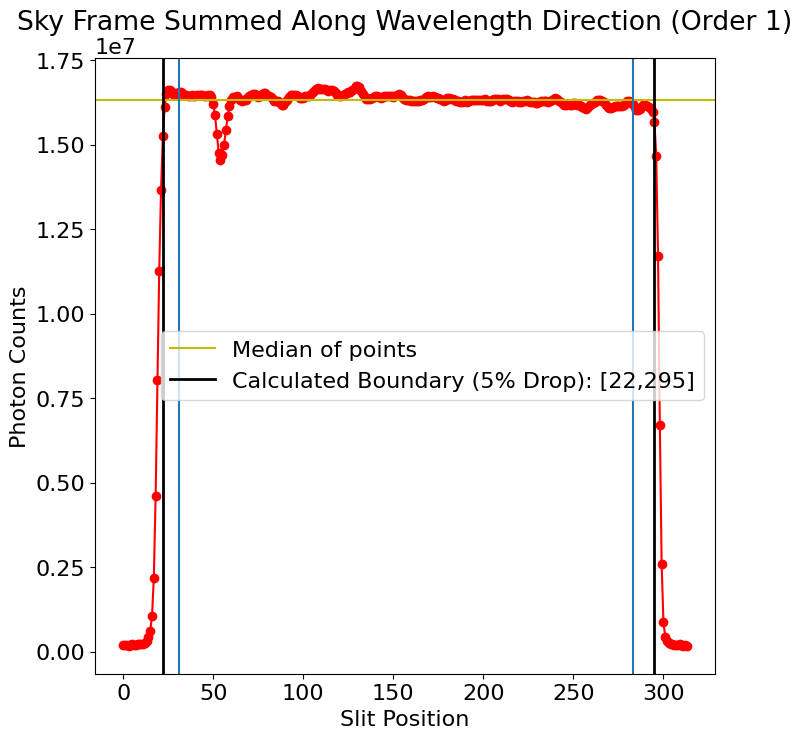

In [108]:
#visualization of median and boundary cutoffs on flat
plt.figure(figsize=(8, 8))
plt.plot(sumsky, "r")
plt.scatter(np.arange(len(sumsky)), sumsky, color = "r")

plt.title("Sky Frame Summed Along Wavelength Direction (Order " + order + ")")
plt.xlabel("Slit Position")
plt.ylabel("Photon Counts")


plt.axhline(y = skysumavg, color = 'y', label = "Median of points")
plt.axvline(x = frontedge, color = "black", linewidth= 2, 
            label = "Calculated Boundary (5% Drop): [" + str(frontedge) + "," + str(backedge) + "]")
plt.axvline(x = backedge, color = "black", linewidth= 2)

plt.axvline(x = bounds_sky)
plt.axvline(x = len(sumsky) - bounds_sky)
plt.legend()

In [109]:
#find better way to pull from fits header?
print("CHECK TO MAKE SURE SLIT LENGTH IS CORRECT")
print("Slit size from fits header: " + str(fitsarray[0].header['SLITNAME']))

if fitsarray[0].header['SLITNAME'] == "0.288x24" or fitsarray[0].header['SLITNAME'] == "0.432x24":
    slitlength = 24 #arcsec
    
else:
    print("Slit Length is not 0.288x24 or 0.432x24 arcsec, input slit length manually")
    slitlength = 24 #If slit length is not 24, change
    
    
print("Slit length inputted: " + str(slitlength))
platescale = fitsarray[0].header['PSCALE']

truepixels = int(slitlength/platescale) #should be 186 pixels for 24 arcsec slit with NIRSPEC post 2019 upgrade
print("The resulting array length is" , truepixels)

CHECK TO MAKE SURE SLIT LENGTH IS CORRECT
Slit size from fits header: 0.288x24
Slit length inputted: 24
The resulting array length is 186


In [110]:
#interpolate the data array to the length of the "real" array
def interparray(data, length):
    slitarray = np.linspace(0, 1, num=length) #create array of values from 0 to 1 the same size as final array
    comparisonarray = np.linspace(0, 1, num=int(len(data[:,1]))) #create array of values from 0 to 1 size of original array
       
    #done like this because we need some comparison to be able to interpolate values to
    #two arrays of different sizes but covering the same span of data lets us do that
    
    arr = []
    for i in range(len(data[1,:])):
        interp = np.interp(slitarray, comparisonarray, data[:,i]) #interpolate array
        arr.append(interp)
       
    return np.array(arr)

In [111]:
index = 0
your_path = path + "/Reduction Files/fcal data"
files = os.listdir(your_path)
for file in files:
    if os.path.isfile(os.path.join(your_path, file)):
        f_name, f_ext = os.path.splitext(os.path.join(your_path, file))
        jup = np.load(os.path.join(your_path, file))
        jup_crop = jup[frontedge:backedge] #crop frames down to size
        jup_interp = interparray(jup_crop, truepixels).T #interpolate to "true" slit size (186)
        index = index + 1
        
        newpath = path + "/Reduction Files/fcal data/interp"
        if not os.path.exists(newpath):
            os.makedirs(newpath)
        
        np.save(
            path + "/Reduction Files/fcal data/interp/" + Path(f_name).stem + "_interp.npy", jup_interp
                )

Y:/obs_23/Keck_29Dec/spec\e1o1/Reduction Files/fcal data/interp/nspec231230_0120_JupN_e1o1_final_interp.npy


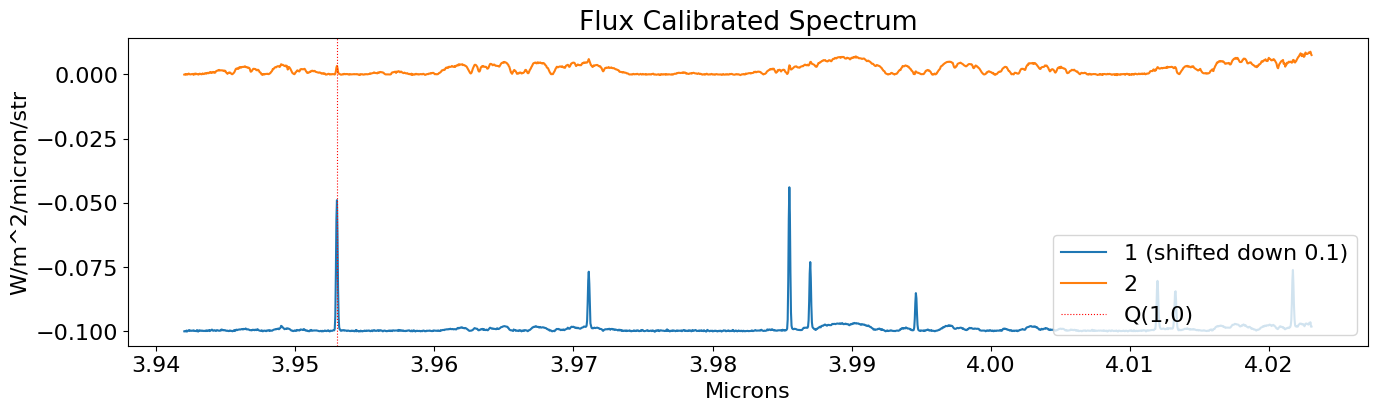

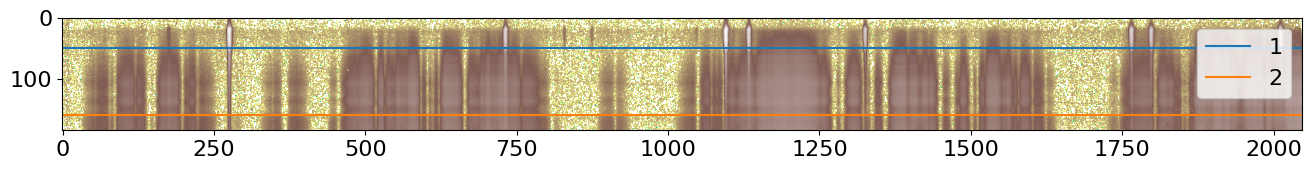

In [113]:
#plot one of the saved data files


index = 0 
your_path = path + "/Reduction Files/fcal data/interp/"
files = os.listdir(your_path)
for file in files:
    if os.path.isfile(os.path.join(your_path, file)):
        jup = np.load(os.path.join(your_path, file), allow_pickle = True)
        index = index + 1
        
        if index == 69: #change this to plot a different file
        
            print(os.path.join(your_path, file))
            num1 = 50
            num2 = 160

            plt.figure(figsize=(16, 4))
            plt.plot(wave_micron, jup[num1]-0.1, label = "1 (shifted down 0.1)")
            plt.plot(wave_micron, jup[num2], label = "2")
            plt.xlabel("Microns")
            plt.ylabel("W/m^2/micron/str")
            plt.title("Flux Calibrated Spectrum")
            #plt.ylim(-.01, .06)
            
            if order == "1":
                plt.axvline(x = 3.95299, color = 'Red', label = "Q(1,0)", linewidth = 0.8, linestyle = ":")
            elif order ==  "4":
                plt.axvline(x = 3.41488, color = "r", linewidth = 0.8, linestyle = ":", label = "R(3,1)")
                plt.axvline(x = 3.42071, color = "r", linewidth = 0.8, linestyle = ":", label = "R(3,2)")
                plt.axvline(x = 3.45475, color = "r", linewidth = 0.8, linestyle = ":", label = "R(4,3)")
                
            plt.legend(loc = "lower right")
            plt.show()
            
            plt.figure(figsize=(16, 4))
            plt.imshow(jup, norm = lognorm(), cmap = "terrain")
            plt.axhline(y = num1, label = "1", color = "tab:blue")
            plt.axhline(y = num2, label = "2", color = "tab:orange")
            plt.legend()
            plt.show()

In [ ]:
Re = 71492 #km
thickness = 800 #km
H = 700 #km
rp = Re + H + thickness
Xp = rp/H 

chiP_list = []
ch_list = []

for chiP in range(0,100,1):
    y = np.sqrt(1/2*Xp)*np.abs(math.cos(math.radians(chiP)))
    
    if y>= 0 and y<8:
        erfc = (1.0606963 + 0.55643831*y)/(1.0619896 + 1.7245609*y + y**2) *np.exp(-1*y**2)
    elif y>= 8 and y<= 100:
        erfc = 0.56498823 / (0.06651874 + y) *np.exp(-1*y**2) 
        
    if np.abs(chiP) > 90:
        ch = np.sqrt(np.pi*2*Xp) *  \
        (np.sqrt(math.sin(math.radians(chiP)))*np.exp(Xp*(1-math.sin(math.radians(chiP)))) - 0.5*np.exp(y**2)*erfc)
    elif np.abs(chiP)<90:
        ch = np.sqrt(np.pi / 2 * Xp) * math.e**y**2 * erfc
    
    
    chiP_list.append(chiP)
    ch_list.append(ch)

In [ ]:
#np.save("chapman_correction.npy", [chiP_list, ch_list])

In [ ]:
plt.plot(chiP_list,ch_list, label = "Chapman")
plt.plot(-1*np.asarray(chiP_list),ch_list, c="tab:blue")
plt.plot(chiP_list, 1/np.cos(np.radians(np.asarray(chiP_list))), label = "cos")
plt.plot(-1*np.asarray(chiP_list),1/np.cos(np.radians(np.asarray(chiP_list))), c="tab:orange")
plt.xlabel("Emission Angle")
plt.ylabel("Line of Sight Correction") #(Chapman's Grazing Incidence Integral Approximation)
plt.ylim(0,100)
#plt.xlim(-90,90)
plt.legend()
plt.show()